In [2]:
import sys
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Wine Predictor") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext
file_location = "winequalityN.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

In [4]:
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [5]:
df.count()

6497

In [5]:
df.first()

Row(type='white', fixed acidity=7.0, volatile acidity=0.27, citric acid=0.36, residual sugar=20.7, chlorides=0.045, free sulfur dioxide=45.0, total sulfur dioxide=170.0, density=1.001, pH=3.0, sulphates=0.45, alcohol=8.8, quality=6)

In [6]:
import pandas as pd
pd.DataFrame(df.take(3), columns = df.columns)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [7]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stringIndexer = StringIndexer(inputCol="type", outputCol="typeIndex")
model = stringIndexer.fit(df)
indexed = model.transform(df)
indexed.show()

+-----+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---------+
| type|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|typeIndex|
+-----+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---------+
|white|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|      0.0|
|white|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|      0.0|
|white|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|      0.0|
|whi

In [8]:
pd.DataFrame(indexed.take(3), columns = indexed.columns)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,typeIndex
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0.0
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0.0
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0.0


In [6]:
from pyspark.sql import functions  as f
df_na = df.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])

In [8]:
import pandas as pd
pd.DataFrame(df_na.take(3),columns = df_na.columns)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,10,8,3,2,2,0,0,0,9,4,0,0


In [9]:
excl = ["type","free sulfur dioxide","total sulfur dioxide","density","alcohol","quality"]
def fill_with_mean(df, exclude=set()): 
    stats = df.agg(*(
        f.avg(c).alias(c) for c in df.columns if c not in exclude
    ))
    df = df.na.fill(stats.first().asDict())

fill_with_mean(df, excl)


In [10]:
from pyspark.ml.feature import Imputer
fill_list = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","pH","sulphates"]
imputer = Imputer(
    inputCols=fill_list, 
    outputCols=["{}_imputed".format(c) for c in fill_list]
)
model = imputer.fit(df)
df2 = model.transform(df)
pd.DataFrame(df2.take(2),columns = df2.columns)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,sulphates_imputed,citric acid_imputed,residual sugar_imputed,volatile acidity_imputed,pH_imputed,fixed acidity_imputed,chlorides_imputed
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,0.45,0.36,20.7,0.27,3.0,7.0,0.045
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,0.49,0.34,1.6,0.30,3.3,6.3,0.049


In [11]:
df2 = df2.drop("fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","pH","sulphates")
pd.DataFrame(df2.take(2),columns = df2.columns)

,type,free sulfur dioxide,total sulfur dioxide,density,alcohol,quality,sulphates_imputed,citric acid_imputed,residual sugar_imputed,volatile acidity_imputed,pH_imputed,fixed acidity_imputed,chlorides_imputed
0,white,45.0,170.0,1.001,8.8,6,0.45,0.36,20.7,0.27,3.0,7.0,0.045
1,white,14.0,132.0,0.994,9.5,6,0.49,0.34,1.6,0.30,3.3,6.3,0.049


In [12]:
#pd.DataFrame(df2.take(3),columns = df2.columns)
df2 = df2.withColumnRenamed('fixed acidity_imputed',"fixed acidity").withColumnRenamed('volatile acidity_imputed',"volatile acidity")\
.withColumnRenamed('citric acid_imputed',"citric acid").withColumnRenamed('residual sugar_imputed',"residual sugar")\
.withColumnRenamed('chlorides_imputed',"chlorides").withColumnRenamed('sulphates_imputed',"sulphates")\
.withColumnRenamed('pH_imputed',"pH")
#df2.show()
pd.DataFrame(df2.take(3),columns = df2.columns)

,type,free sulfur dioxide,total sulfur dioxide,density,alcohol,quality,sulphates,citric acid,residual sugar,volatile acidity,pH,fixed acidity,chlorides
0,white,45.0,170.0,1.0010,8.8,6,0.45,0.36,20.7,0.27,3.00,7.0,0.045
1,white,14.0,132.0,0.9940,9.5,6,0.49,0.34,1.6,0.30,3.30,6.3,0.049
2,white,30.0,97.0,0.9951,10.1,6,0.44,0.40,6.9,0.28,3.26,8.1,0.050


In [18]:
features = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,StringIndexer
assembler_features = VectorAssembler(inputCols = features,outputCol = 'features')
labelIndexer = StringIndexer(inputCol ='type',outputCol='typeIndex').setHandleInvalid("skip")
stages = []
stages += [assembler_features,labelIndexer]


In [19]:
white_wine = df2.filter('type == "white"')

In [20]:
red_wine = df2.filter('type == "red"')

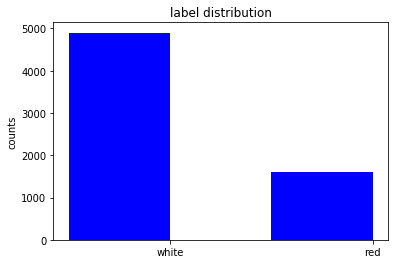

In [15]:
import numpy as np 
import matplotlib.pyplot as plt 
responses = df2.groupBy ('type'). count (). collect () 
categories = [i [0] for i in responses] 
counts = [i [1] for i in responses] 
ind = np.array (range ( len (categories))) 
width = 0.5 
plt.bar (ind, counts, width = width, color = 'b') 
plt.ylabel ('counts') 
plt.title ('label distribution') 
plt.xticks (ind + width / 2., categories) 
plt.show ()

In [21]:
sampleRatio = float (red_wine.count ()) / float (df.count ())
white_wine = white_wine.sample (False, sampleRatio)
df2 = white_wine.unionAll (red_wine)

In [57]:
print(sampleRatio)

0.2461135908881022


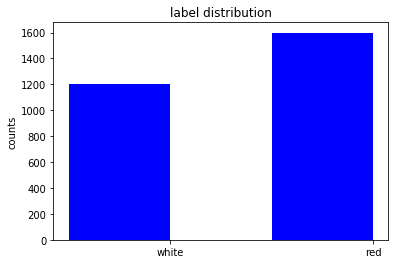

In [22]:
responses = df2.groupBy ('type'). count (). collect () 
categories = [i [0] for i in responses] 
counts = [i [1] for i in responses] 
ind = np.array (range ( len (categories))) 
width = 0.5 
plt.bar (ind, counts, width = width, color = 'b') 
plt.ylabel ('counts') 
plt.title ('label distribution') 
plt.xticks (ind + width / 2., categories) 
plt.show ()

In [23]:
red_wine.count()

1599

In [24]:
white_wine.count()

1203

In [25]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)


In [26]:
pd.DataFrame(df2.take(3),columns = df2.columns)

,type,free sulfur dioxide,total sulfur dioxide,density,alcohol,quality,sulphates,citric acid,residual sugar,volatile acidity,pH,fixed acidity,chlorides
0,white,47.0,186.0,0.9956,9.9,6,0.40,0.32,8.5,0.23,3.19,7.2,0.058
1,white,48.0,143.0,0.9912,12.4,7,0.52,0.40,1.5,0.16,3.54,6.6,0.044
2,white,28.0,112.0,0.9914,11.4,7,0.55,0.38,1.5,0.17,3.25,6.6,0.032


In [27]:
allData = pipeline.fit(df2).transform(df2)
allData.cache()
trainingData, testData = allData.randomSplit([0.7,0.3], seed=0)

#print("Distribution of 0 and 1 in trainingData is: ", trainingData.groupBy("typeIndex").count().take(3))

In [28]:
trainingData = trainingData.drop("type")
testData = testData.drop("type")

In [29]:
#trainingData.show()
pd.DataFrame(trainingData.take(3),columns = trainingData.columns)


,free sulfur dioxide,total sulfur dioxide,density,alcohol,quality,sulphates,citric acid,residual sugar,volatile acidity,pH,fixed acidity,chlorides,features,typeIndex
0,3.0,89.0,0.98993,11.4,4,0.30,0.28,1.25,0.27,2.95,7.1,0.023,"[7.1, 0.27, 0.28, 1.25, 0.023, 3.0, 89.0, 0.98...",1.0
1,4.0,10.0,0.99246,13.5,4,0.36,0.12,1.10,0.65,3.32,4.8,0.013,"[4.8, 0.65, 0.12, 1.1, 0.013, 4.0, 10.0, 0.992...",1.0
2,5.0,24.0,0.99110,11.9,6,0.36,0.31,2.85,0.37,3.19,7.9,0.037,"[7.9, 0.37, 0.31, 2.85, 0.037, 5.0, 24.0, 0.99...",1.0


In [30]:
trainingData = trainingData.withColumnRenamed('typeIndex','label')
testData = testData.withColumnRenamed('typeIndex','label')

In [31]:

#RandomForest
from pyspark.ml.classification import RandomForestClassifier as RF
rf = RF(labelCol='label', featuresCol='features',numTrees=200)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)

In [32]:
pd.DataFrame(transformed.take(3),columns = transformed.columns)

,free sulfur dioxide,total sulfur dioxide,density,alcohol,quality,sulphates,citric acid,residual sugar,volatile acidity,pH,fixed acidity,chlorides,features,label,rawPrediction,probability,prediction
0,3.0,18.0,0.99368,10.0,6,0.54,0.49,4.9,0.24,2.85,9.7,0.032,"[9.7, 0.24, 0.49, 4.9, 0.032, 3.0, 18.0, 0.993...",1.0,"[101.33528098320654, 98.66471901679343]","[0.5066764049160328, 0.4933235950839672]",0.0
1,4.0,10.0,0.99246,13.5,4,0.36,0.12,1.1,0.65,3.32,4.8,0.013,"[4.8, 0.65, 0.12, 1.1, 0.013, 4.0, 10.0, 0.992...",1.0,"[108.14774026728522, 91.85225973271477]","[0.5407387013364261, 0.45926129866357385]",0.0
2,4.0,28.0,0.98931,12.0,6,0.36,0.30,0.9,0.20,3.20,7.1,0.019,"[7.1, 0.2, 0.3, 0.9, 0.019, 4.0, 28.0, 0.98931...",1.0,"[36.70754283776753, 163.29245716223244]","[0.18353771418883766, 0.8164622858111623]",1.0


In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(transformed)


In [33]:
print("Accuracy = " + str(rf_accuracy))
print("Error = %g " % (1.0 - rf_accuracy))

Accuracy = 0.9831121833534379
Error = 0.0168878 


In [34]:
predict_labels = transformed.select("prediction","label")
pred_label_rdd = predict_labels.rdd

In [35]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(pred_label_rdd)
#print("Area under Precision/Recall (PR) curve: %.3f" % (metrics.areaUnderPR * 100))
multi_metrics = MulticlassMetrics(pred_label_rdd)
print("Precision: %.3f" % (multi_metrics.precision() * 100))
print("Recall: %.3f" % (multi_metrics.recall() * 100))
f1measure = multi_metrics.fMeasure()
print("F1 Score: %.3f"%(f1measure*100))

Precision: 98.311
Recall: 98.311
F1 Score: 98.311


In [36]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

In [37]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(transformed)

0.9974008863336926

In [38]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(trainingData)

In [39]:
predictions = cvModel.transform(testData)

In [43]:
evaluator.evaluate(predictions)

0.9979089913372498

In [40]:
#Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)


In [41]:
dtModel = dt.fit(trainingData)

In [42]:
dt_predictions = dtModel.transform(testData)

In [43]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(dt_predictions)

0.9417714696370822

In [44]:
predict_labels = dt_predictions.select("prediction","label")
pred_label_rdd = predict_labels.rdd
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(pred_label_rdd)
#print("Area under Precision/Recall (PR) curve: %.3f" % (metrics.areaUnderPR * 100))
multi_metrics = MulticlassMetrics(pred_label_rdd)
print("Precision: %.3f" % (multi_metrics.precision() * 100))
print("Recall: %.3f" % (multi_metrics.recall() * 100))
f1measure = multi_metrics.fMeasure()
print("F1 Score: %.3f"%(f1measure*100))

Precision: 95.778
Recall: 95.778
F1 Score: 95.778


In [45]:
dt_paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1,2,6,10])
             .addGrid(dt.maxBins, [20,40,80])
             .build())
cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
dt_cvModel = cv.fit(trainingData)
# Takes ~5 minutes

In [46]:
dt_predictions = dt_cvModel.transform(testData)
evaluator.evaluate(dt_predictions)

0.9786201940352137

In [47]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(trainingData)
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)


In [48]:
predict_labels = predictions.select("prediction","label")
pred_label_rdd = predict_labels.rdd
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(pred_label_rdd)
#print("Area under Precision/Recall (PR) curve: %.3f" % (metrics.areaUnderPR * 100))
multi_metrics = MulticlassMetrics(pred_label_rdd)
print("Precision: %.3f" % (multi_metrics.precision() * 100))
print("Recall: %.3f" % (multi_metrics.recall() * 100))
f1measure = multi_metrics.fMeasure()
print("F1 Score: %.3f"%(f1measure*100))

Precision: 58.384
Recall: 58.384
F1 Score: 58.384
